In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, MuonGun

import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

mpl.rcParams['hist.bins'] = 100
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['patch.linewidth'] = 2.5
mpl.rcParams['grid.alpha'] = 0.2

__reading from file__
-------------------------------

here I'm readig from 1 file; 
you can add file loop later.

In [3]:
fr_arr = []; mctree_arr = []

with dataio.I3File('MCdata/83.i3.bz2') as f:
    for fr in f:
        if f.stream.id != 'Q': continue
        fr_arr.append( fr )
        mctree_arr.append( fr['I3MCTree'] )

some functions to use

In [72]:
def path_len(pos1, pos2):                                  
    return np.sqrt((pos2.x-pos1.x)**2+(pos2.y-pos1.y)**2+(pos2.z-pos1.z)**2)

def path_len_mmc(mmc_tr):                                  
    return np.sqrt((mmc_tr.xf-mmc_tr.xi)**2+(mmc_tr.yf-mmc_tr.yi)**2+(mmc_tr.zf-mmc_tr.zi)**2)

def muon_dEdx(mctree, prim):                               
    dgths = mctree.get_daughters(prim)                                      
    el = []; L = []
    
    for i in range(len(dgths)-1):
        L.append( path_len(dgths[i].pos, dgths[i+1].pos) )
        el.append( dgths[1:][i].energy )
        
    el = np.array(el); L = np.array(L)     
    dEdx = el/L
    return dEdx, L


here I'm using two ways to get average -dE/dx for each muon

from looking at variables in the frame one can think of a few ways to get -dE/dx, but first we need to check what these variables __actually mean__.

here I'm using two ways to calculate <-dE/dx> (I'm not sure about both of them, but )

In [76]:
av_dEdx = []
dEdx = []
l = []

for fr in fr_arr: 
    for i in range(len(fr['MMCTrackList'])):
        mu = fr['MMCTrackList'][i].GetI3Particle()                              
        mctree = fr['I3MCTree']
    
        mu_dEdx, leng = muon_dEdx(mctree, mu)
        l.append( np.sum(leng) )
        dEdx.append( mu_dEdx )
        av_dEdx.append( np.mean(mu_dEdx) )

av_dEdx = np.array(av_dEdx)
dEdx = np.array(dEdx)
l = np.array(l)

In [58]:
mmc_Ei = []; mmc_Ef = []
mmc_Elost = []
mmc_path = []

for fr in fr_arr: 
    for i in range(len(fr['MMCTrackList'])):
        mmc_tr = fr['MMCTrackList'][i]                              
    
        mmc_Ei.append( mmc_tr.Ei / icetray.I3Units.GeV )
        mmc_Ef.append( mmc_tr.Ef / icetray.I3Units.GeV )
        mmc_Elost.append( mmc_tr.Elost / icetray.I3Units.GeV )
        mmc_path.append( path_len_mmc(mmc_tr) )

mmc_Ei = np.array(mmc_Ei); mmc_Ef = np.array(mmc_Ef)
mmc_Elost = np.array(mmc_Elost)
mmc_path = np.array(mmc_path)

# Muon selection

we want MIP muons. First, let's cut these with energies much bigger than 'MIP region'.

From `https://edoc.hu-berlin.de/bitstream/handle/18452/15655/Kowalski.pdf?sequence=1&isAllowed=y`: I'll take 500 GeV as a point, where radiative losses are starting to dominate.

- _this is just my example, you should check it and, maybe, try to figure out better threshold!_

let's see how our muon energy is distributed.

/home/maria/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


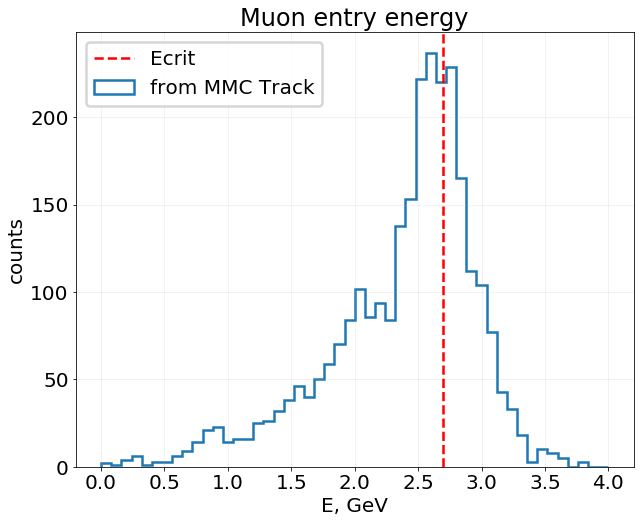

In [86]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon entry energy')
ax.set_ylabel('counts')
ax.set_xlabel('E, GeV')

plt.hist(np.log10(mmc_Ei), 50, range=[0.,4.], 
         histtype='step', label='from MMC Track') 

ax.axvline(np.log10(500.), c='r', linestyle='--', label='Ecrit')

ax.grid()
plt.legend(loc=2)
plt.show()

cut them

In [87]:
en_cut = (mmc_Ei<500.)

/home/maria/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


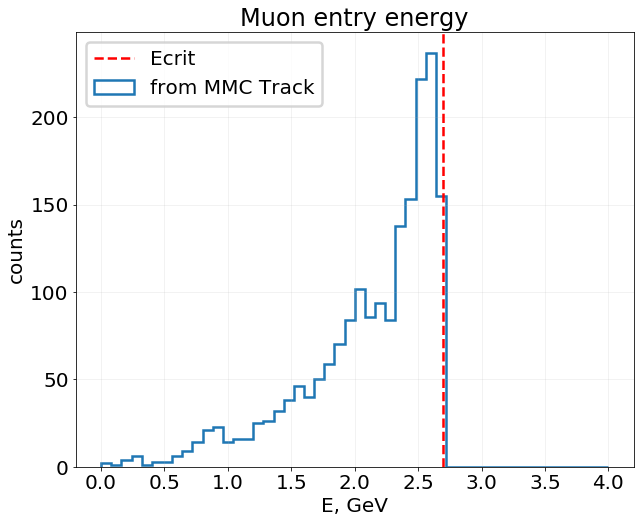

In [88]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon entry energy')
ax.set_ylabel('counts')
ax.set_xlabel('E, GeV')

plt.hist(np.log10(mmc_Ei[en_cut]), 50, range=[0.,4.], 
         histtype='step', label='from MMC Track') 

ax.axvline(np.log10(500.), c='r', linestyle='--', label='Ecrit')

ax.grid()
plt.legend(loc=2)
plt.show()

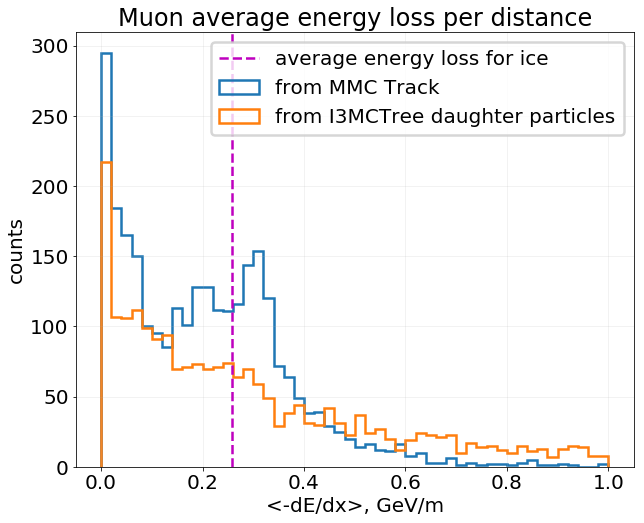

In [50]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon average energy loss per distance')
ax.set_ylabel('counts')
ax.set_xlabel('<-dE/dx>, GeV/m')

plt.hist(mmc_Elost/mmc_path, 50, range=[0.,1.], 
         histtype='step', label='from MMC Track') 
plt.hist(av_dEdx, 50, range=[0.,1.], 
         histtype='step', label='from I3MCTree daughter particles') 

plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')
ax.grid()
plt.legend()
plt.show()

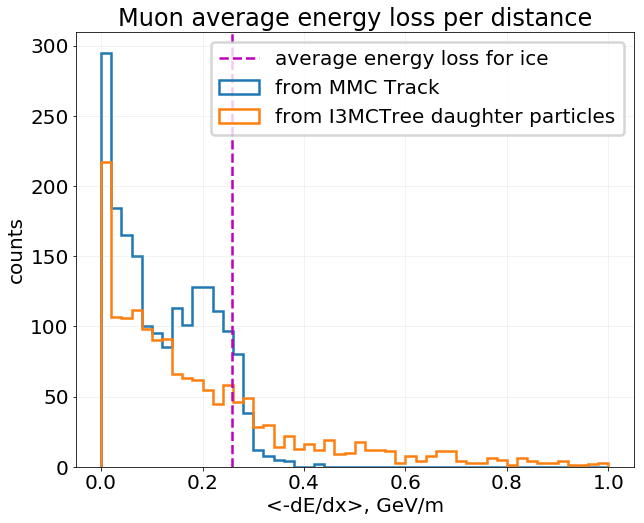

In [89]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon average energy loss per distance')
ax.set_ylabel('counts')
ax.set_xlabel('<-dE/dx>, GeV/m')

plt.hist((mmc_Elost/mmc_path)[en_cut], 
         50, range=[0.,1.], 
         histtype='step', label='from MMC Track') 
plt.hist(av_dEdx[en_cut], 50, range=[0.,1.], 
         histtype='step', label='from I3MCTree daughter particles') 

plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')
ax.grid()
plt.legend()
plt.show()

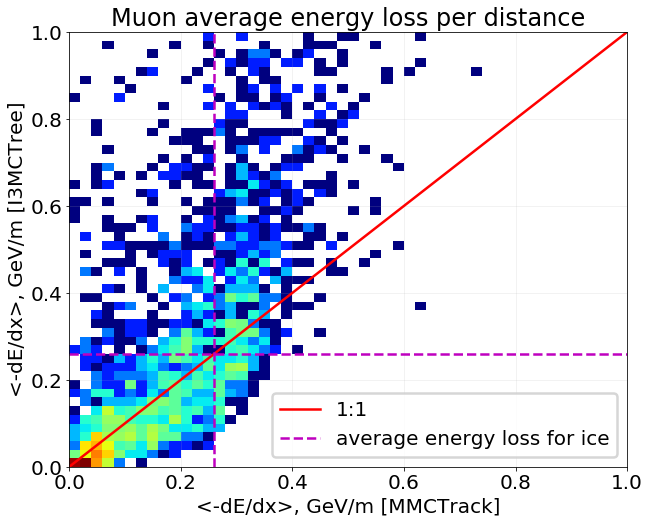

In [91]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon average energy loss per distance')
ax.set_ylabel('<-dE/dx>, GeV/m [I3MCTree]')
ax.set_xlabel('<-dE/dx>, GeV/m [MMCTrack]')

plt.hist2d((mmc_Elost/mmc_path), av_dEdx, 
           50, range=[[0.,1.],[0.,1.]], 
           cmap='jet',
           norm=LogNorm()) 

plt.plot([0.,1.], [0.,1.], 'r-', label='1:1')
plt.axhline(0.259, c='m', linestyle='--')
plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')

ax.grid()
plt.legend()
plt.show()

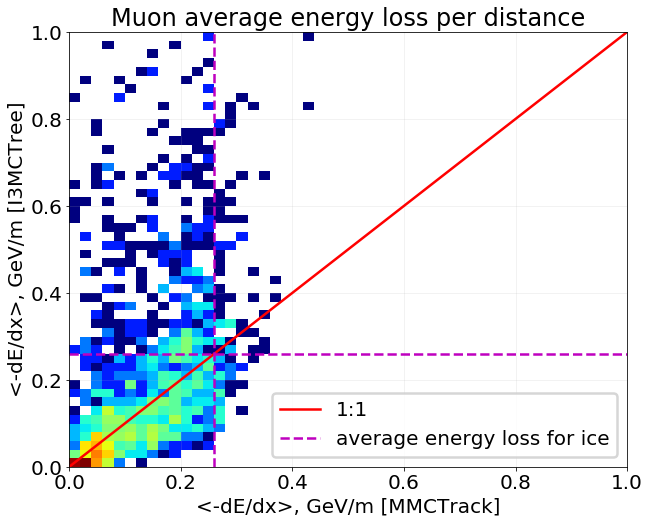

In [90]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon average energy loss per distance')
ax.set_ylabel('<-dE/dx>, GeV/m [I3MCTree]')
ax.set_xlabel('<-dE/dx>, GeV/m [MMCTrack]')

plt.hist2d((mmc_Elost/mmc_path)[en_cut], av_dEdx[en_cut], 
           50, range=[[0.,1.],[0.,1.]], 
           cmap='jet',
           norm=LogNorm()) 

plt.plot([0.,1.], [0.,1.], 'r-', label='1:1')
plt.axhline(0.259, c='m', linestyle='--')
plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')

ax.grid()
plt.legend()
plt.show()

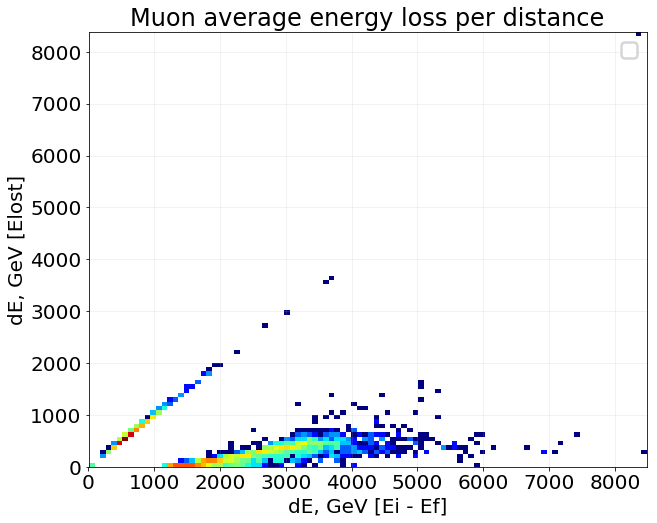

In [63]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon average energy loss per distance')
ax.set_xlabel('dE, GeV [Ei - Ef]')
ax.set_ylabel('dE, GeV [Elost]')

plt.hist2d(mmc_Ei-mmc_Ef, mmc_Elost, 100,
           cmap='jet',
           norm=LogNorm()) 

# plt.plot([0.,1.], [0.,1.], 'r-', label='1:1')
# plt.axhline(0.259, c='m', linestyle='--')
# plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')

ax.grid()
plt.legend()
plt.show()

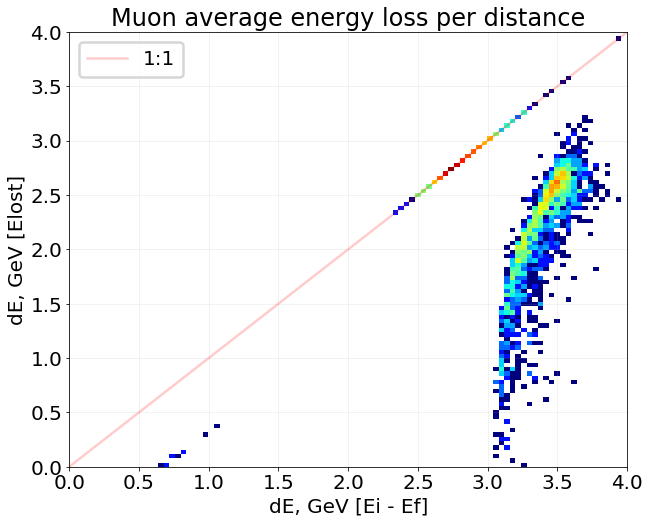

In [71]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon average energy loss per distance')
ax.set_xlabel('dE, GeV [Ei - Ef]')
ax.set_ylabel('dE, GeV [Elost]')

plt.hist2d(np.log10(mmc_Ei-mmc_Ef), np.log10(mmc_Elost), 100, range=[[0.,4.],[0.,4.]],
           cmap='jet',
           norm=LogNorm()) 

plt.plot([0.,5.], [0.,5.], 'r-', label='1:1', alpha=0.2)
# plt.axhline(0.259, c='m', linestyle='--')
# plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')

ax.grid()
plt.legend()
plt.show()

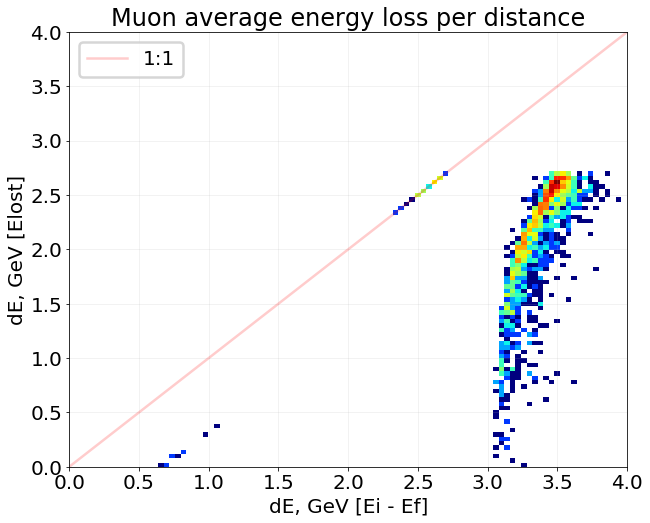

In [92]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon average energy loss per distance')
ax.set_xlabel('dE, GeV [Ei - Ef]')
ax.set_ylabel('dE, GeV [Elost]')

plt.hist2d(np.log10(mmc_Ei-mmc_Ef)[en_cut], np.log10(mmc_Elost)[en_cut], 100, range=[[0.,4.],[0.,4.]],
           cmap='jet',
           norm=LogNorm()) 

plt.plot([0.,5.], [0.,5.], 'r-', label='1:1', alpha=0.2)
# plt.axhline(0.259, c='m', linestyle='--')
# plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')

ax.grid()
plt.legend()
plt.show()

- wtf? why is energy deposit != Efinal - Eini??